# Análisis predictivo de series temporales

-----

## Modelos de media móvil

In [24]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import numpy as np
import statsmodels.api as sm
import pandas as pd

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

### Repaso: procesos autorregresivos

Recordemos primero la definición de proceso autorregresivo (de media 0):

> **Definición:** un proceso $\{x_t\}$ es autorregresivo de orden $p$ si admite la representación
>
> $$ x_t = \phi_1 x_{t-1} + \ldots + \phi_p x_{t-p} + w_t,$$
>
> con $w_t$ ruido blamco de varianza $\sigma_w^2$.

### Autocorrelación y autocorrelación parcial

En un proceso autorregresivo puro:

* La autocorrelación decae de forma exponencial como función del lag.
* La autocorrelación parcial se anula para lags mayores a $p$.

## Proceso de media móvil

> **Definición:** un proceso $\{x_t\}$ es una media móvil de orden $q$ o $MA(q)$ si verifica:
>
> $$ x_t = w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q},$$
>
> donde hay $q$ lags en la media móvil, $\theta_1,\ldots,\theta_q$ son parámetros, $\theta_q\neq0$ y $\{w_t\}$ es ruido blanco (Gaussiano) de varianza $\sigma^2_w$. 

* Es el proceso dual del AR, donde el valor actual depende de valores pasados del ruido solamente, y no de la propia serie. 
* El ruido blanco puede pensarse como una media móvil de orden $0$.
* Si $q>0$ el proceso es más suave que el ruido puro.

### Ejemplo: MA(1)

Consideremos el proceso:
$$x_t = w_t + \theta w_{t-1}$$
con $w_t$ ruido blanco de varianza $\sigma_w^2=1$ y $\theta=0.9$.

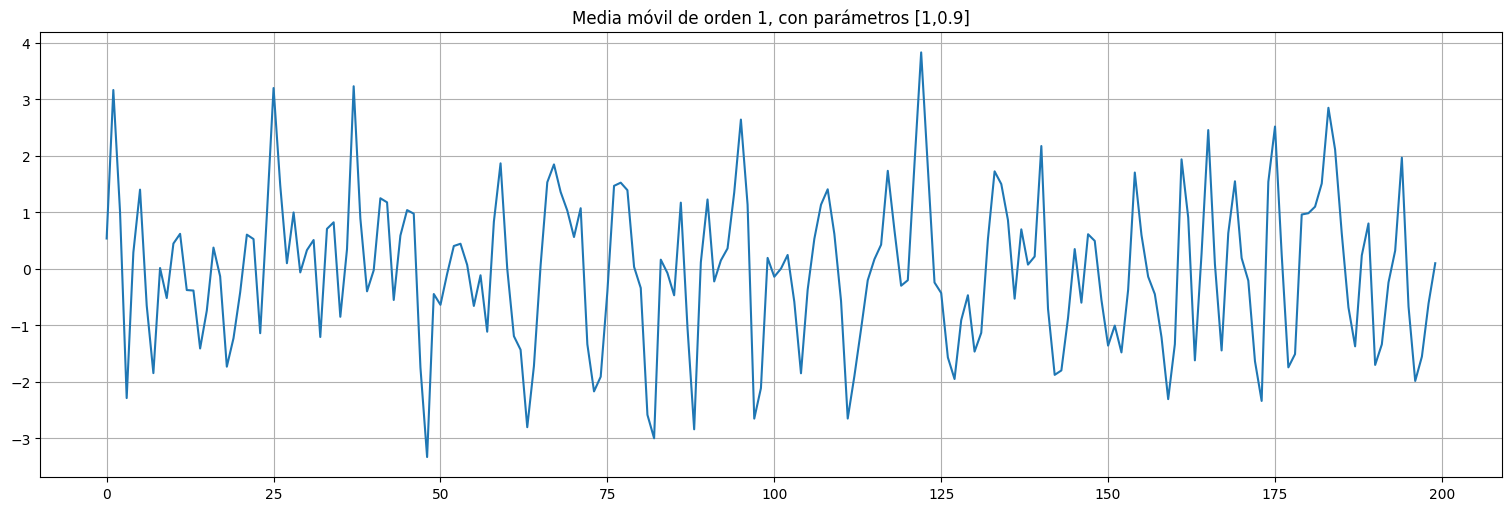

In [2]:
## Ejemplo: media movil de orden 1
from statsmodels.tsa.arima_process import arma_generate_sample

theta = 0.9
#primer parámetro: coeficientes autorregresivos. Segundo parámetro: coeficientes de media móvil
#El tercer parámetro es la cantidad de muestras.
x=arma_generate_sample([1],[1,theta],200)
x=pd.Series(x)
x.plot();
plt.title(f"Media móvil de orden 1, con parámetros [1,{theta}]");

### Ejemplo: media móvil de orden variable

Consideremos para cada $n$ el proceso:
$$x_t = \frac{1}{n} \left(w_{t} + w_{t-1} + \ldots + w_{t-n+1}\right)$$
con $w_t$ ruido blanco de varianza $\sigma^2_w=1$.

Observar que este proceso es una media móvil de orden $q = n-1$. Lo podemos escribir como:
$$n x_t = w_{t} + w_{t-1} + \ldots + w_{t-n+1}$$
Esta es la parametrización que le pasamos a `arma_generate_sample`:


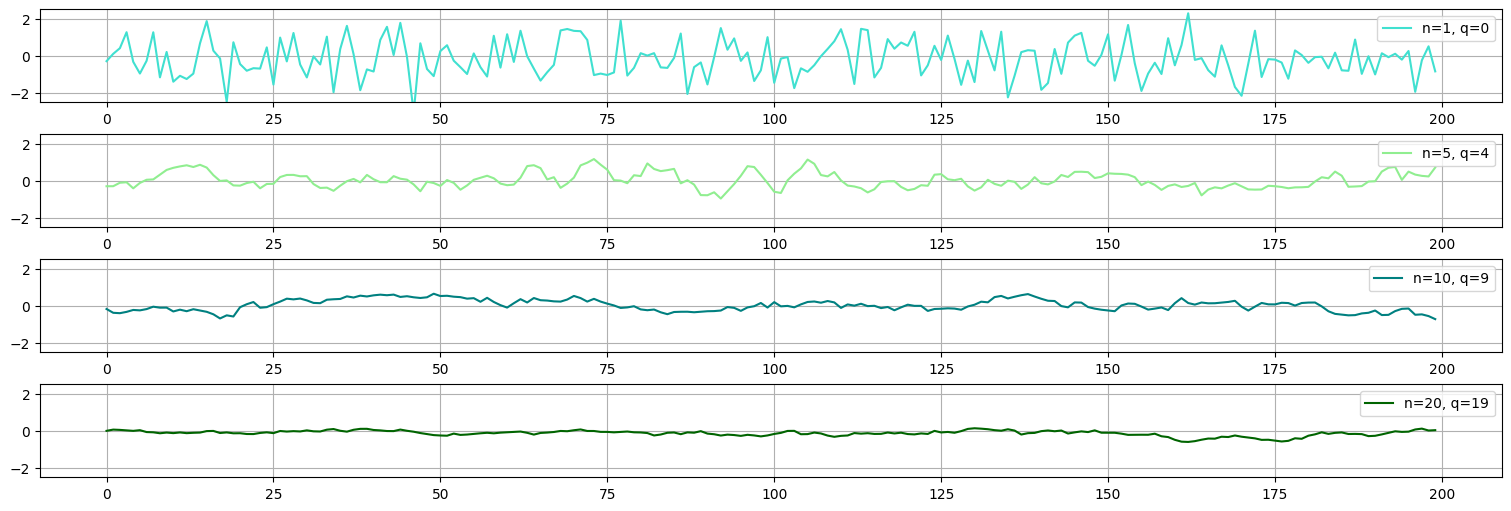

In [3]:
## Ejemplo: media movil de orden variable
j=1
cmap = ['turquoise','lightgreen','teal','darkgreen']
for n in [1,5,10,20]:
    q=n-1
    x=arma_generate_sample([n],np.ones(n),200)
    x=pd.Series(x)
    plt.subplot(4,1,j)
    plt.plot(x,label=f"n={n}, q={q}", color=cmap[j-1]);
    plt.ylim(-2.5,2.5)
    plt.legend(loc='upper right');
    j=j+1


### Ejemplo: media movil de orden 1

El proceso MA(1) está dado por

$$ x_t = w_t + \theta w_{t-1}.$$

**Propiedades**:

* $E[x_t] = E[w_t] + \theta E[w_{t-1}] = 0$.
* $E[x_t^2] = E[w_t^2] +  2\theta E[w_tw_{t-1}] + \theta^2 E[w_{t-1}^2] = (1+\theta^2)\sigma^2_w.$
* $E[x_t x_{t-1}] = E[(w_t + \theta w_{t-1})(w_{t-1} + \theta w_{t-2})] = \theta \sigma^2_w.$
* $E[x_t x_{t-h}] = 0$ si $h>1$ porque los ruidos que participan no están correlacionados.

Resumiendo, la función de autocovarianza de un MA(1) tiene la forma:

$$\gamma(h) = \left\{\begin{array}{ll}(1+\theta^2)\sigma_w^2 & h=0\\ \theta\sigma_w^2 & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

La función de autocorrelación es entonces:

$$\rho(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$


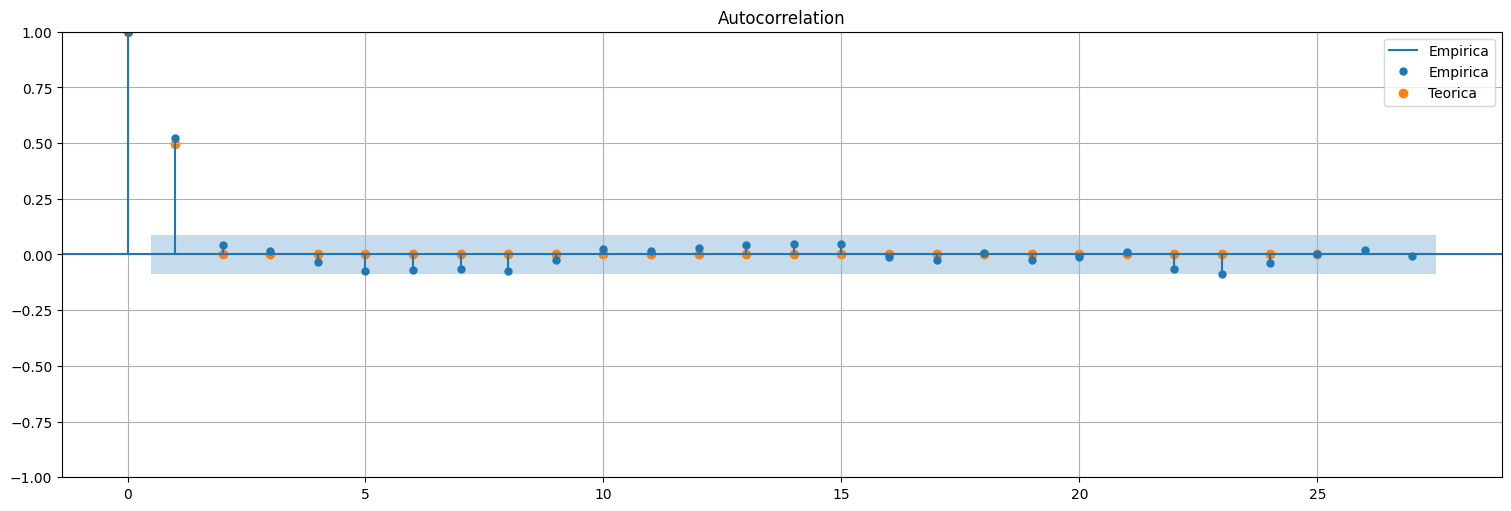

In [4]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
theta=0.9
x=arma_generate_sample([1],[1,theta],500)
x=pd.Series(x)
plot_acf(x,bartlett_confint=False, label="Empirica");
plt.scatter(range(0,26),np.concatenate(([1],[theta/(1+theta**2)], np.zeros(24))), label="Teorica");
plt.legend();

### Observación

La propiedad anterior es general, es decir, si $x_t$ es un proceso $MA(q)$ entonces la ACF de $x_t$ es $0$ para lags $h>q$. Probemos con uno de orden $q=5$ y coeficientes arbitrarios

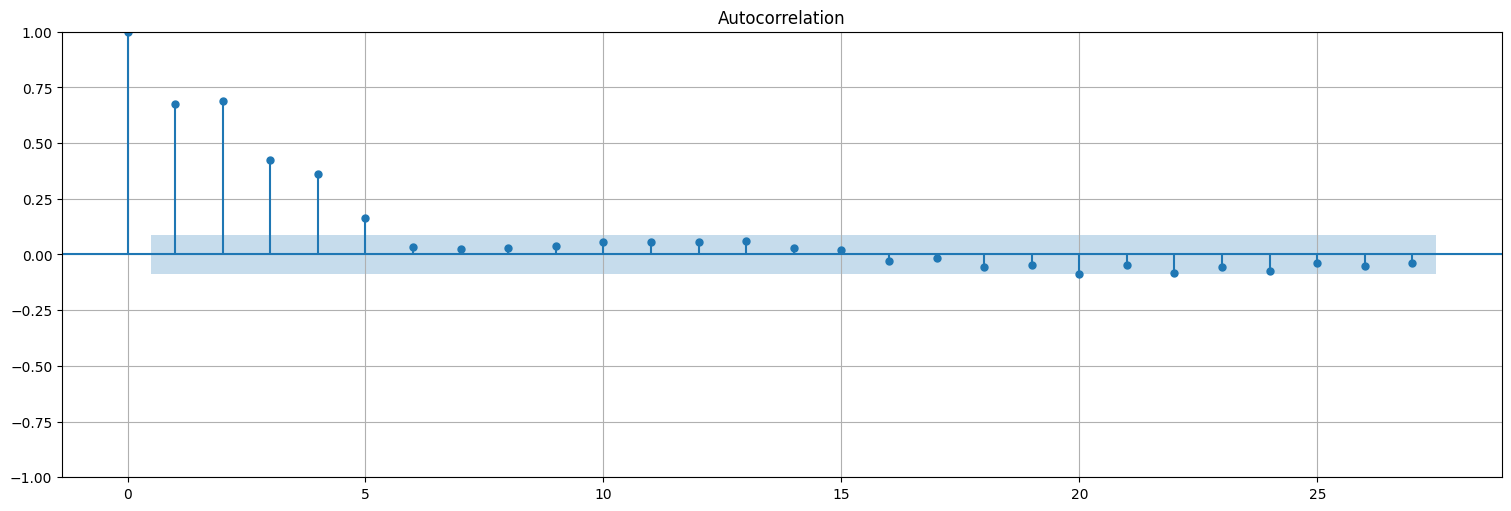

In [5]:
x=arma_generate_sample([1],[1,.5,1,.5,1,.5],500)
x=pd.Series(x)
plot_acf(x,bartlett_confint=False, label="Empirica");

En cambio, la PACF no tiene el mismo comportamiento:

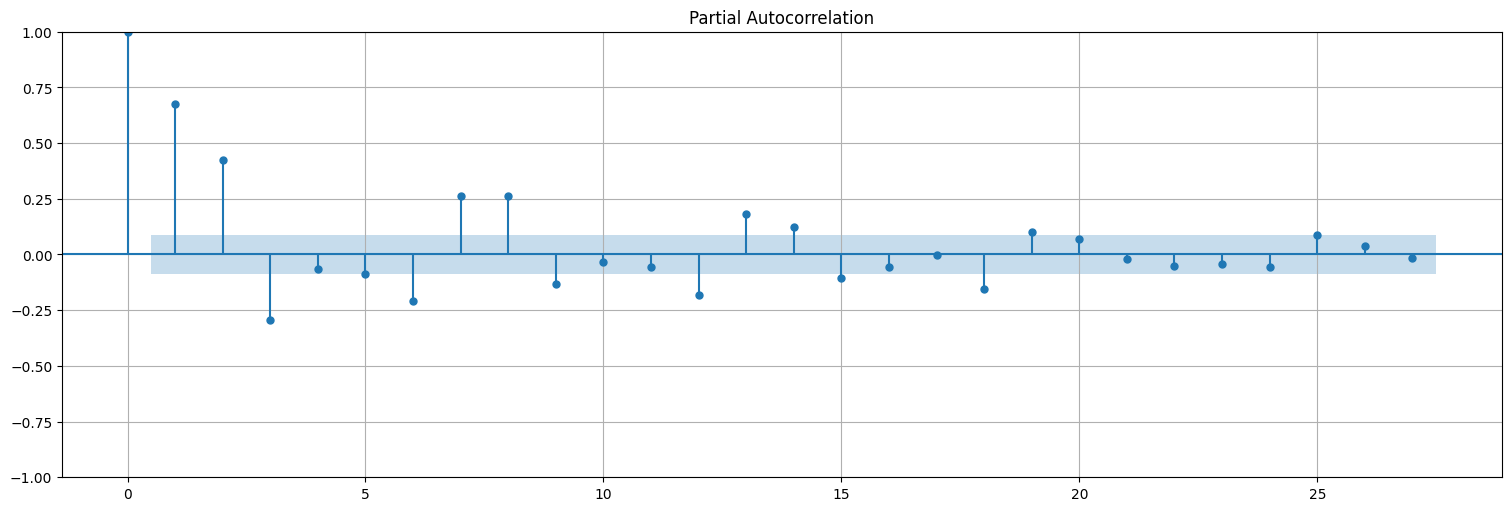

In [6]:
plot_pacf(x, label="Empirica");

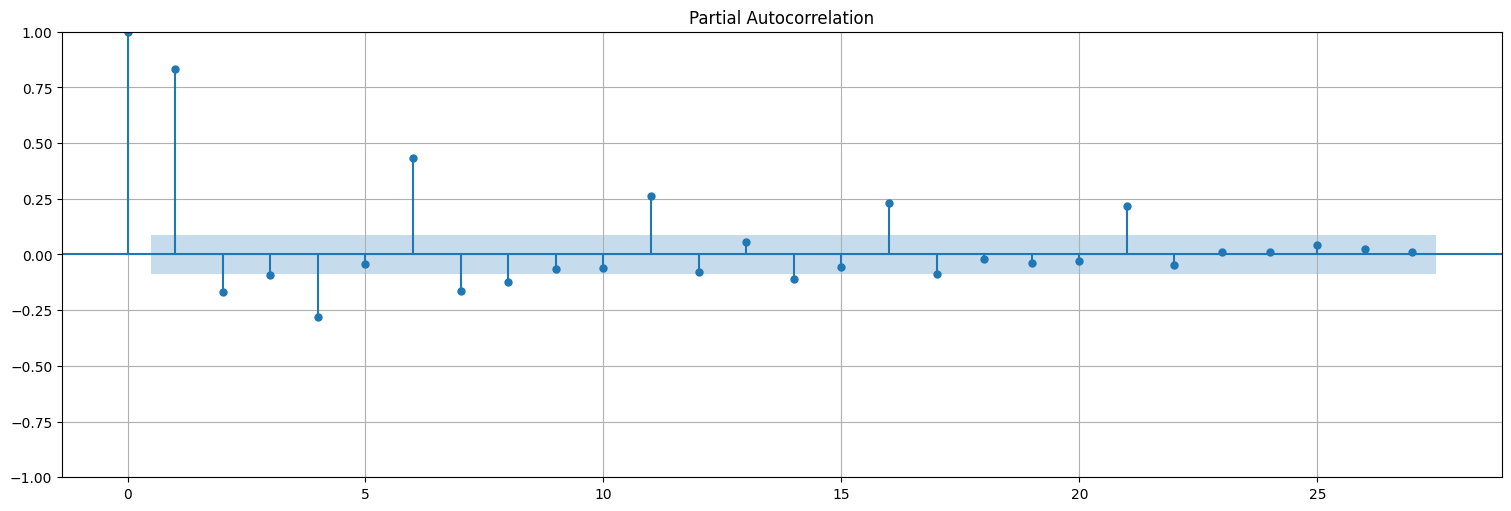

In [7]:
n=5
x=arma_generate_sample([n],np.ones(n),500)
x=pd.Series(x)
plot_pacf(x);

### Resumen:

En el proceso $MA(q)$ :

* La función de autocorrelación tiene $q$ lags activos.
* La función de autocorrelación parcial decae lentamente

Es decir, a la inversa de lo que ocurre en AR.

### Ajuste de un proceso $MA(q)$

Comencemos por el $MA(1)$ dado por:

$$x_t = w_t + \theta w_{t-1}.$$

El proceso $w_t$ no es directamente observable, entonces no podemos hacer una regresión a sus valores anteriores. Deberíamos "despejar" $w_t$ de algún modo.

Observemos la siguiente recursión:

$$ \left.\begin{array}{c}
    x_t = w_t + \theta w_{t-1} \\
    x_{t-1} = w_{t-1} + \theta w_{t-2}\end{array}\right\} \Rightarrow x_t = w_t + \theta x_{t-1} -\theta^2 w_{t-2}$$
    
Siguiendo la recursión, si $|\theta|<1$ el modelo se dice *invertible* y podemos escribir:

$$ x_{t} = \sum_{j=1}^\infty (-\theta)^j x_{t-j} +w_t$$

es decir, convertimos un $MA(1)$ en un $AR(\infty)$ en cierto modo. Como $\theta^j$ es decreciente, podríamos hacer una regresión y tratar de adivinar $\theta$.

**Problema**: Es no lineal en $\theta$ lo que estamos buscando.

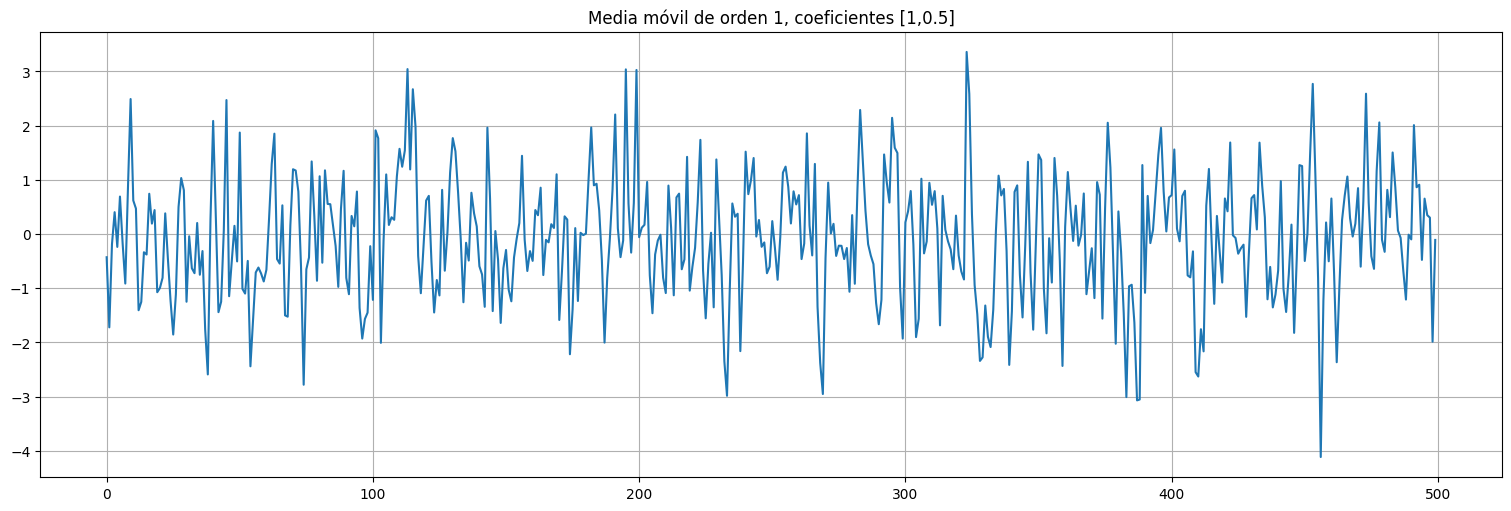

In [8]:
## Ejemplo: simulo un MA(1) con theta = 0.5 y hago varios fits
theta=0.5
x=arma_generate_sample([1],[1,theta],500)
x=pd.Series(x)
x.plot(title=f"Media móvil de orden 1, coeficientes [1,{theta}]");

In [9]:
from statsmodels.formula.api import ols

data = pd.concat([x, x.shift(1)], axis=1).dropna()
data.columns = ["x", "xL1"]

fit = ols("x ~ 0+xL1", data=data).fit()
print(f"MSE de los residuos: {fit.mse_resid}")
fit.summary()

MSE de los residuos: 1.1321455224760901


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.139
Model:                            OLS   Adj. R-squared (uncentered):              0.137
Method:                 Least Squares   F-statistic:                              80.29
Date:                Wed, 15 May 2024   Prob (F-statistic):                    6.49e-18
Time:                        15:27:31   Log-Likelihood:                         -738.52
No. Observations:                 499   AIC:                                      1479.
Df Residuals:                     498   BIC:                                      1483.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.3726      0.042      8.961      0.000       0.291       0.454
==============================================================================
Omnibus:                        1.061   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.866
Skew:                           0.043   Prob(JB):                        0.649
Kurtosis:                       3.185   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
data = pd.concat([x, x.shift(1), x.shift(2)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2"]

fit = ols("x ~ 0+xL1+xL2", data=data).fit()
print(f"MSE de los residuos: {fit.mse_resid}")
fit.summary()

MSE de los residuos: 1.092015408289203


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.169
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              50.41
Date:                Wed, 15 May 2024   Prob (F-statistic):                    1.17e-20
Time:                        15:27:31   Log-Likelihood:                         -727.55
No. Observations:                 498   AIC:                                      1459.
Df Residuals:                     496   BIC:                                      1468.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.4414      0.044     10.027      0.000       0.355       0.528
xL2           -0.1877      0.044     -4.250      0.000      -0.274      -0.101
==============================================================================
Omnibus:                        0.973   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.615   Jarque-Bera (JB):                0.779
Skew:                           0.031   Prob(JB):                        0.677
Kurtosis:                       3.184   Cond. No.                         1.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
data = pd.concat([x, x.shift(1), x.shift(2), x.shift(3)], axis=1).dropna()
data.columns = ["x", "xL1", "xL2", "xL3"]

fit = ols("x ~ 0+xL1+xL2+xL3", data=data).fit()
print(f"MSE de los residuos: {fit.mse_resid}")
fit.summary()

MSE de los residuos: 1.0937240000124973


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      x   R-squared (uncentered):                   0.171
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              33.95
Date:                Wed, 15 May 2024   Prob (F-statistic):                    5.74e-20
Time:                        15:27:31   Log-Likelihood:                         -725.97
No. Observations:                 497   AIC:                                      1458.
Df Residuals:                     494   BIC:                                      1471.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
xL1            0.4513      0.045     10.037      0.000       0.363       0.540
xL2           -0.2080      0.049     -4.284      0.000      -0.303      -0.113
xL3            0.0451      0.045      1.001      0.317      -0.043       0.134
==============================================================================
Omnibus:                        1.173   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.986
Skew:                           0.036   Prob(JB):                        0.611
Kurtosis:                       3.206   Cond. No.                         1.82
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Problema:** el procedimiento anterior no es muy práctico, y si quisiéramos hacer regresión no lineal necesitamos un buen estimador inicial de $\theta$. Además no generaliza bien a $q$.

**Método de los momentos:** es otra idea válida, recordemos la función de autocorrelación del $MA(1)$.


$$\rho(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

Si estimamos la correlación de orden uno de los datos (es decir la `acf(x)` en el lag $1$) podemos plantear:

$$\hat{\rho} (1) = \hat{\rho} = \frac{\theta}{1+\theta^2},$$

y despejar $\theta$:
$$\hat{\rho} \theta^2 - \theta + \hat{\rho} = 0.$$

Es decir:
$$\theta = \frac{1 \pm \sqrt{1-4\hat{\rho}^2}}{2 \hat{\rho}}.$$

**Observación**: dos soluciones!! ¿Cuál elijo? ¿Y además qué pasa si da complejo?

* Se elije la "invertible", es decir aquella que da menor a $1$.
* En teoría $\rho(1)<0.5$ si $\theta<1$ entonces no puede dar complejo. Pero al estimar $\rho$ por $\hat{\rho}$ puede ocurrir.
* Para estimar $\sigma^2_w$, la varianza del ruido, podemos usar que $\sigma^2_x = (1+\theta^2)\sigma^2_w$ y usar el valor de $\theta$ estimado.

Autocorrelación estimada a lag 1: ρ(1)=0.3695201339806881
Ajuste por método de los momentos: θ=0.44157099718703724


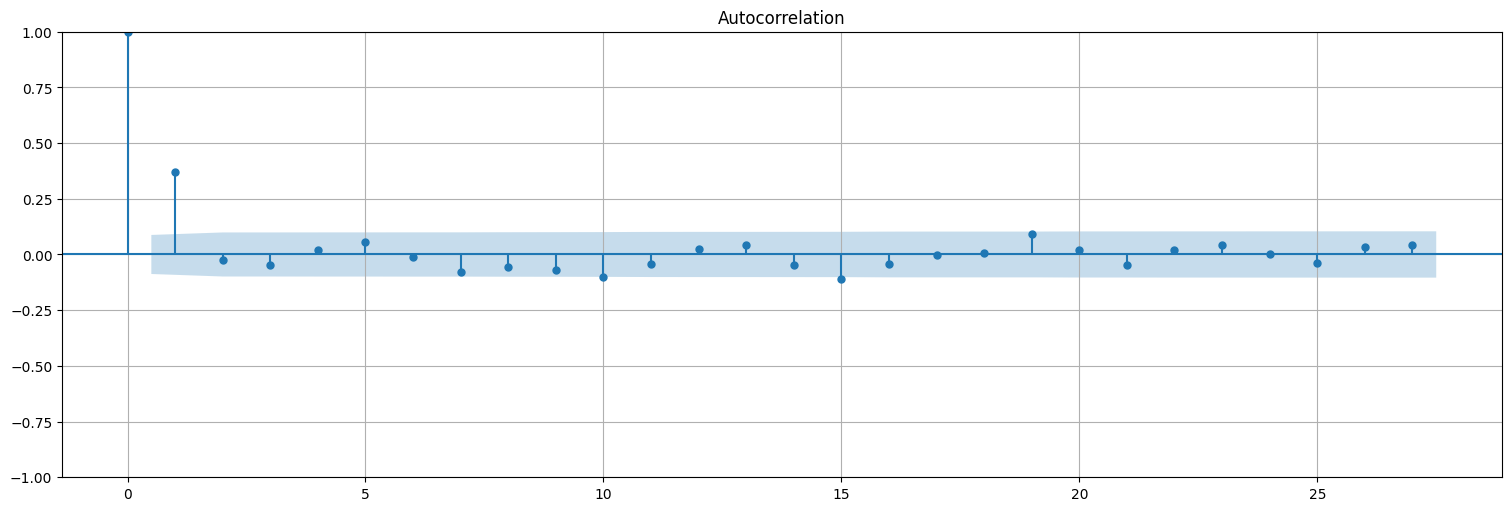

In [12]:
#### Ejemplo
from statsmodels.tsa.api import acf
plot_acf(x)
rho = acf(x)[1]
theta = (1-np.sqrt(1-4*rho**2))/(2*rho)

print(f"Autocorrelación estimada a lag 1: ρ(1)={rho}")
print(f"Ajuste por método de los momentos: θ={theta}")

In [13]:
# Estimo la varianza del ruido por método de los momentos despejando (debería dar 1 en este caso).
sigma_w2 = np.var(x)/(1+theta**2)
print(f"Varianza estimada de wt: {sigma_w2}")

Varianza estimada de wt: 1.0906859134834652


* El método de los momentos se puede generalizar a mayor orden, y también se puede utilizar en el caso $AR(p)$ (donde se denominan Ecuaciones de Yule-Walker). 

* Sin embargo, en la práctica, estos estimadores no son los más eficientes. En general, si los ruidos son gaussianos, conviene usar un enfoque de *máxima verosimilitud*. Este es el método que utiliza la biblioteca `statsmodels` de `python`.

* Discutiremos más este método en relación al modelo completo ARMA, pero a modo de adelanto, hagamos el fit de este último modelo por máxima verosimilitud.


In [14]:
# Ejemplo
from statsmodels.tsa.api import ARIMA

#La funcion ARIMA permite ajustar modelos autorregresivos integrados y de media móvil. 
#En este caso solo usamos el coeficiente de media móvil.
#El parámetro trend="n" es porque el proceso ya está centrado (le sacamos el intercept)
fit = ARIMA(x,order=(0,0,1), trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -731.052
Date:                Wed, 15 May 2024   AIC                           1466.104
Time:                        15:27:31   BIC                           1474.533
Sample:                             0   HQIC                          1469.411
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4419      0.042     10.537      0.000       0.360       0.524
sigma2         1.0897      0.065     16.739      0.000       0.962       1.217
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.91   Prob(JB):                         0.48
Heteroskedasticity (H):               1.14   Skew:                             0.04
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

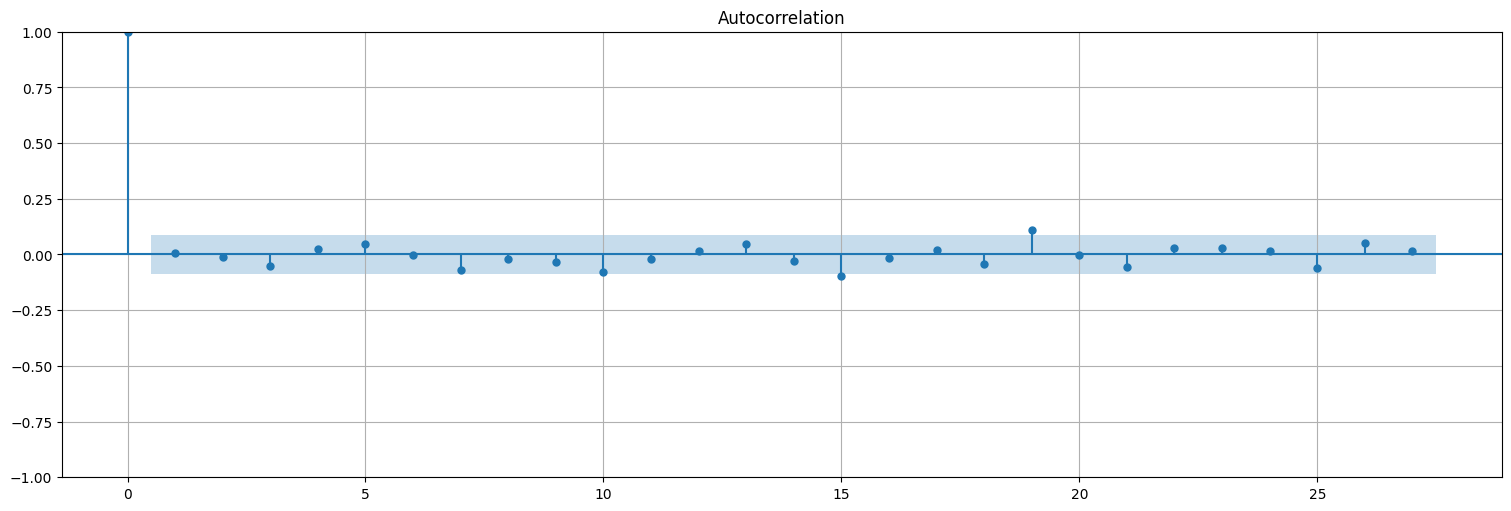

In [15]:
res = fit.resid
plot_acf(res, bartlett_confint=False);

## Modelos ARMA

Un modelo $ARMA(p,q)$ es simplemente la combinación de los dos modelos vistos anteriormente. En términos matemáticos, $x_t$ es un modelo ARMA si se verifica:

$$x_t = \phi_1 x_{t-1} + \ldots + \phi_p x_{t-p} + w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q}$$

con $\phi_p$ y $\theta_q$ distintos de $0$. Los coeficientes $\phi_j$ son los coeficientes de la parte autorregresiva, y los $\theta_j$ los de la parte media móvil. Como siempre, $w_t$ es ruido blanco (gaussiano) de varianza $\sigma^2_w$.

### Notación alternativa

Recordemos que podemos reescribir la ecuación anterior como:

$$x_t - \phi_1 x_{t-1} - \ldots - \phi_p x_{t-p} =  w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q}$$

O bien:

$$\sum_{i=0}^p a_i x_t = \sum_{j=0}^q b_j w_j$$

Identificando $a_0=1$, $a_i = -\phi_i$, $b_0=1$ y $b_j = \theta_j$. Esta es la parametrización estándar en `python.statsmodels`.

### Ejemplo: ARMA(1,1)

Consideremos el siguiente proceso:

$$x_t = \phi x_{t-1} + w_t + \theta w_{t-1}$$

Con $\phi = 0.9$, $\theta = 0.5$.

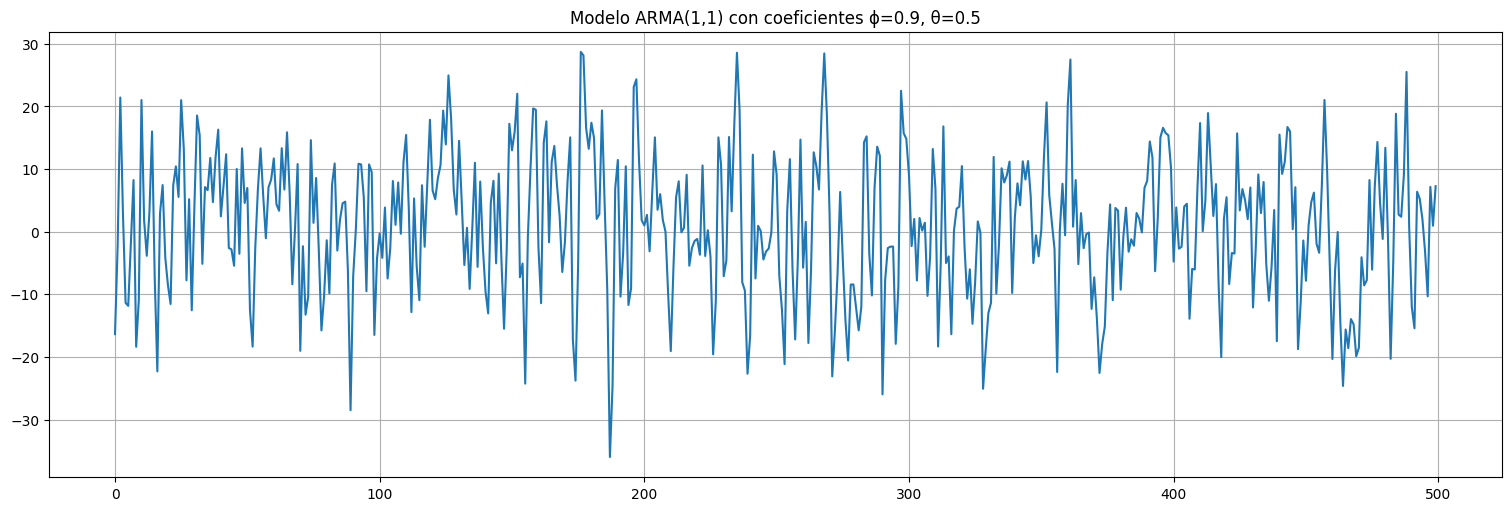

In [16]:
## Ejemplo: simulo un MA(1) con theta = 0.5 y hago varios fits
phi=0.9
theta=0.5
x=arma_generate_sample([1 -phi],[1,theta],500)
x=pd.Series(x)
x.plot(title=f"Modelo ARMA(1,1) con coeficientes ϕ={phi}, θ={theta}");

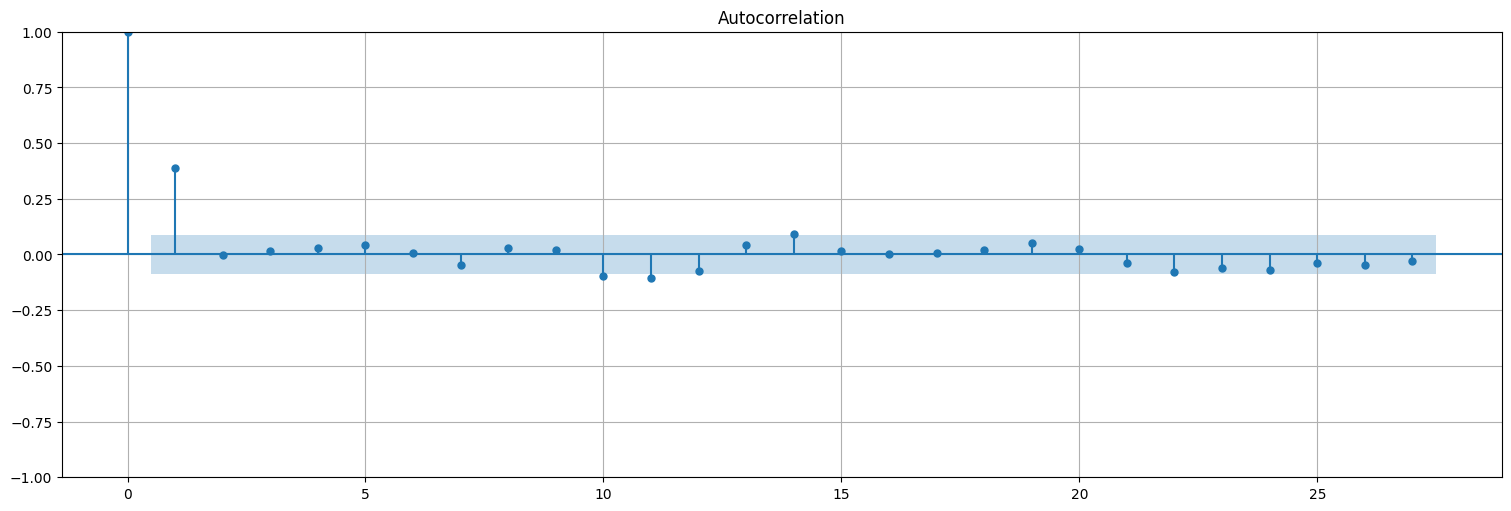

In [17]:
plot_acf(x,bartlett_confint=False);

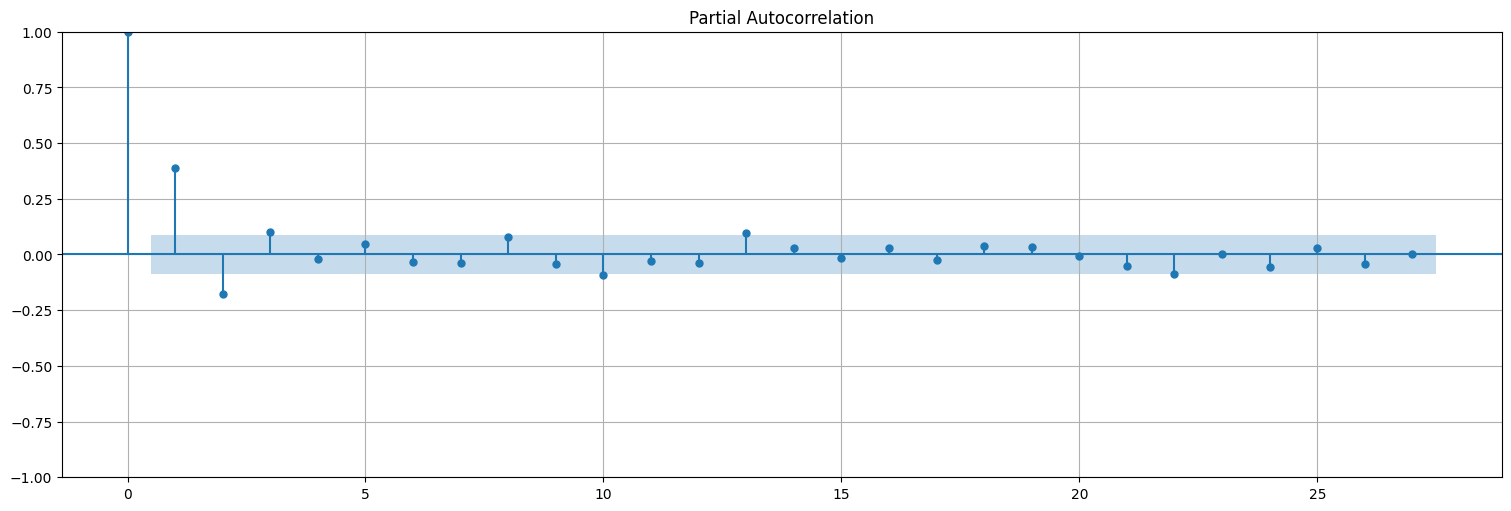

In [18]:
plot_pacf(x);

**Problema:** Ahora la ACF y PACF no son tan claros estimadores del orden del modelo!!

En general, para un modelo ARMA(p,q) *tanto las ACF como la PACF decaen a 0 exponencialmente*.

Aquí no queda otra que "probar" el orden y cortar en base a algún criterio tipo el AIC o BIC.

### Ajuste de un modelo ARMA(1,1)

In [19]:
fit = ARIMA(x,order=(0,0,1), trend="n").fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1867.164
Date:                Wed, 15 May 2024   AIC                           3738.328
Time:                        15:27:32   BIC                           3746.757
Sample:                             0   HQIC                          3741.635
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4834      0.041     11.674      0.000       0.402       0.565
sigma2       102.5390      6.937     14.780      0.000      88.942     116.136
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.66
Prob(Q):                              0.91   Prob(JB):                         0.06
Heteroskedasticity (H):               0.86   Skew:                            -0.24
Prob(H) (two-sided):                  0.32   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

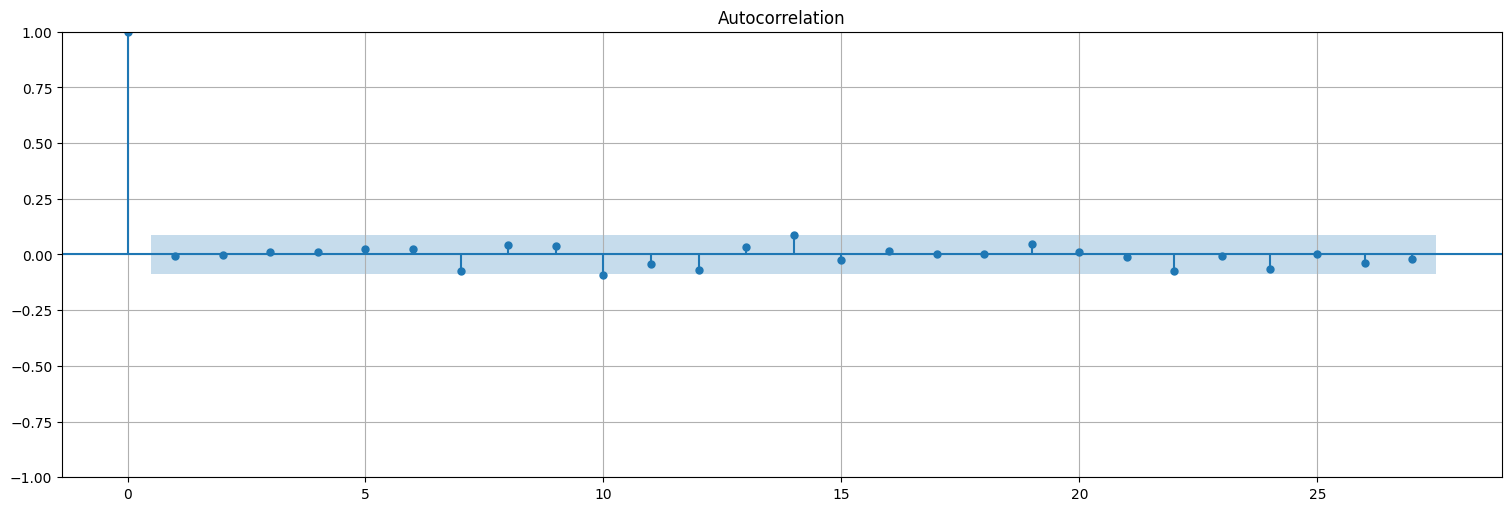

In [20]:
res = fit.resid
plot_acf(res, bartlett_confint=False);

### Causalidad, invertibilidad.

**Observación**: No todos los juegos de parámetros $\phi_j$, $\theta_j$ son posibles. Algunos juegos de parámetros pueden producir procesos *no estacionarios*, o con parámetros no bien definidos.

**Ejemplo:** Consideremos un proceso $AR(1)$ con $|\phi_1| > 1$, se tiene que:

$$x_t = \phi_1 x_{t-1} + w_t.$$

Este proceso amplifica el valor de la muestra anterior. Eventualmente explota!

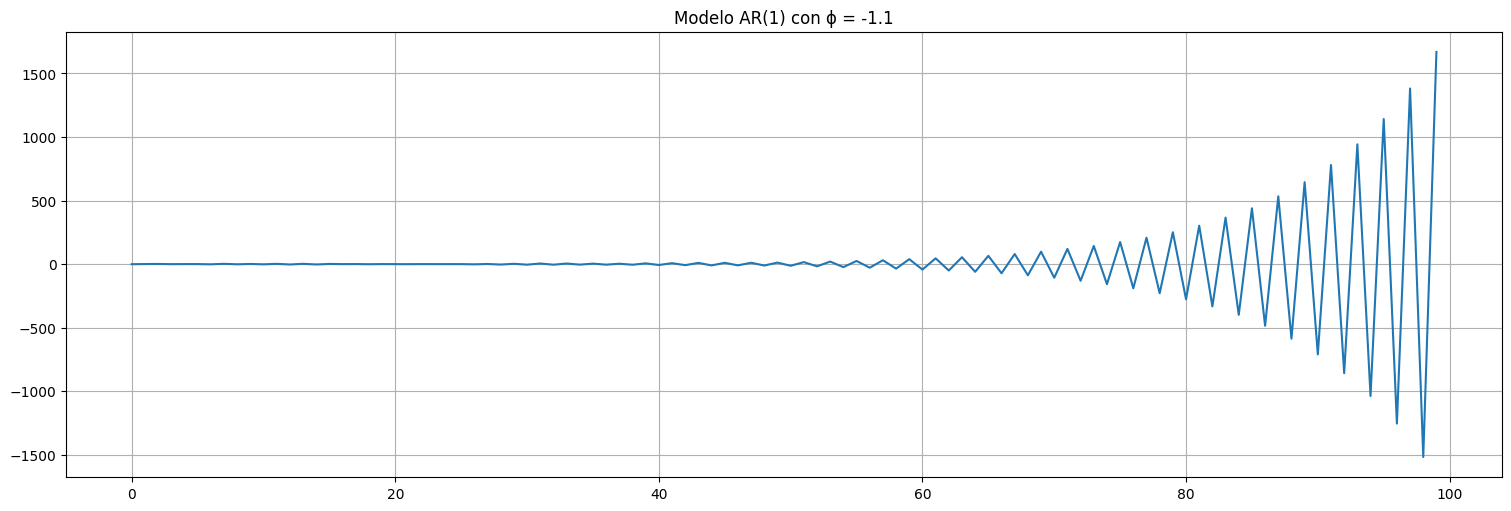

In [21]:
# AR con explosion
phi=-1.1
x=arma_generate_sample([1,-phi],[1],100)
x=pd.Series(x)
x.plot()
plt.title(f"Modelo AR(1) con ϕ = {phi}");

#### Polinomios del AR y MA:

Se definen los siguiente polinomios, asociados a los coeficientes de la parte AR y MA:

$$\phi(z) = 1-\phi_1 z - \phi_2 z^2 -\ldots -\phi_p z^p,$$

$$\theta(z) = 1+\theta_1 z + \theta_2 z^2  + \ldots + \theta_q z^q.$$


#### Causalidad:

Un proceso ARMA es causal si se puede escribir solo como función de las innovaciones pasadas:

$$x_t = \sum_{j=0}^\infty \psi_j \phi_{t-j}.$$
con coeficientes $\psi$ a determinar y $\sum_{j=0}^\infty |\psi_j| <\infty$.

**Teorema:** Un proceso ARMA(p,q) es causal (no explosivo) si y solo si las raíces del polinomio $\phi(z)$ están todas fuera del círculo unitario (es decir, |z|>1 en toda raíz).

**Ejemplo:** Si $x_t$ es un AR(1), entonces $\phi(z) = 1-\phi_1 z$, y la raíz está fuera de $[-1,1]$ si y solo si $|\phi_1|<1$.


#### Invertibilidad:

Un proceso ARMA es invertible si se puede "despejar" $w_t$ de los valores pasados del proceso:

$$w_t = \sum_{j=0}^\infty \pi_j x_{t-j},$$
con coeficientes $\pi$ a determinar y $\sum_{j=0}^\infty |\pi_j| <\infty$.

**Teorema:** Un proceso ARMA(p,q) es invertible si y solo si las raíces del polinomio $\theta(z)$ están todas fuera del círculo unitario (es decir, |z|>1 en toda raíz).

In [22]:
## Ejemplos
from statsmodels.tsa.api import ArmaProcess

print("Ejemplo 1: AR(1) inestable")
proc = ArmaProcess.from_coeffs(-1.1,0)
print(proc)
print(f"Es estacionario? -> {proc.isstationary}")

print("Ejemplo 2: ARMA(1,1) como antes")
proc = ArmaProcess.from_coeffs(.9,.5)
print(proc)
print(f"Es estacionario? -> {proc.isstationary}")
print(f"Es invertible? -> {proc.isinvertible}")


Ejemplo 1: AR(1) inestable
ArmaProcess
AR: [1.0, 1.1]
MA: [1.0, 0.0]
Es estacionario? -> False
Ejemplo 2: ARMA(1,1) como antes
ArmaProcess
AR: [1.0, -0.9]
MA: [1.0, 0.5]
Es estacionario? -> True
Es invertible? -> True


### Parámetros del ajuste de un modelo ARMA

El ajuste se realiza entonces mediante *máxima verosimilitud* o *métodos de los momentos*, buscando siempre un modelo *causal* e *invertible*.

## Ejercicio

Analizar la serie de grosor glacial del paquete `astsa` (serie `varve`). Aplicar la transformación `diff(log(x))` para obtener una serie estacionaria y discutir el ajuste de un modelo $MA(q)$ y $ARMA(p,q)$. 

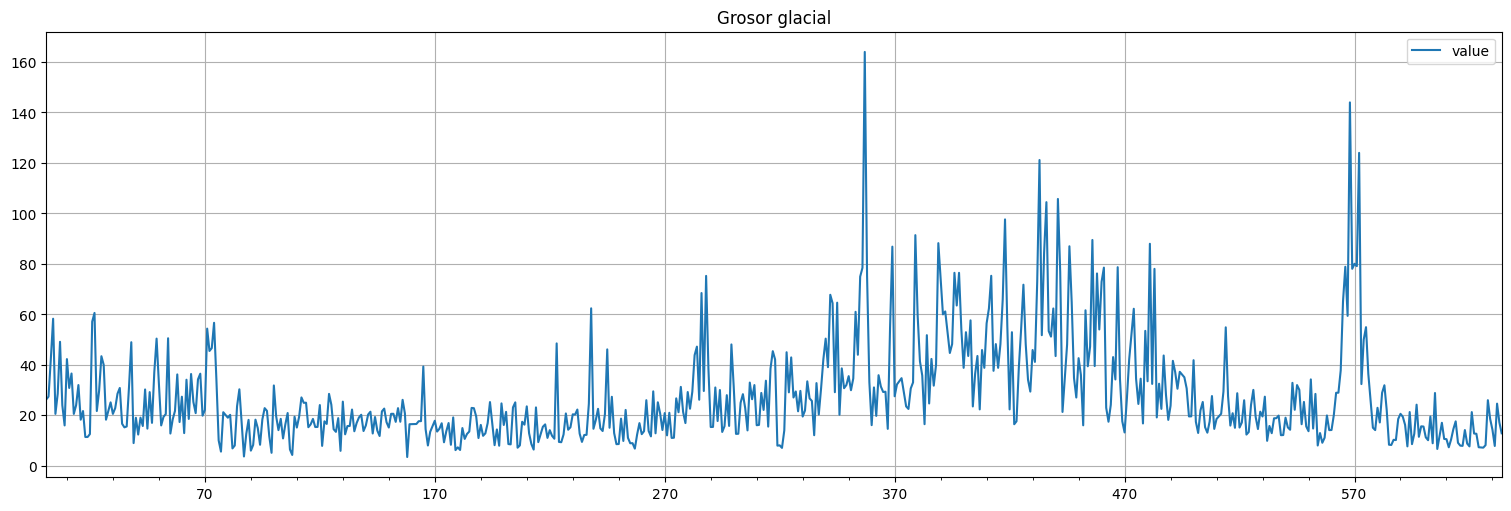

In [23]:
varve=astsa.varve
varve.plot();
plt.title("Grosor glacial");